# 回帰分析を実行するプログラム

In [1]:
import sys
sys.path.append('..')
from Constants import Constants

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import re

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import seaborn
import pyperclip

import scipy.stats


In [3]:
pd.set_option('display.max_columns', 50)

### ここだけ手動で設定。変更がないか毎度確認すること

In [4]:
pvalue_index = -1

### 分析対象のファイルのパスを正規表現で取得

In [5]:
pathes = glob.glob(f"{Constants.path_to_matlab_repository_folder}/csv/?_*/HRV_and_PLI.csv")
pathes.sort()
pathes

['/Users/miyakooti/repositories/arai_MATLAB_program/csv/0_kumakura/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/1_kim/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/2_souma/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/3_fujii/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/4_tubota/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/5_toki/HRV_and_PLI.csv']

# StatsModelsを利用した分析

- [公式ドキュメント](https://www.statsmodels.org/stable/index.html#citation)
- [github](https://github.com/statsmodels/statsmodels)

Seabold, Skipper, and Josef Perktold. “statsmodels: Econometric and statistical modeling with python.” Proceedings of the 9th Python in Science Conference. 2010.

In [6]:
import statsmodels.api as sm

### フェーズごとの分析

In [7]:
for i,target_phase in enumerate(Constants.target_phases):
    
    for j,path in enumerate(pathes):

        df = pd.read_csv(path,index_col=0).fillna(0)
        # column
        # row
        df = df.loc[[target_phase]] # seriesとして取り出したいときはこっち
        if j == 0:
            flow_dataset = df
        else:
            flow_dataset = pd.concat([flow_dataset, df], axis=0)
    
    export_data = {    
        "target": Constants.target_columns,
        "linear-p": [],
        "linear-rsquared": [],
        "linear-rsquared_adj": [],
        "linear-coef": [],
        "nonlinear-p": [],
        "nonlinear-rsquared": [],
        "nonlinear-rsquared_adj": [],
        "nonlinear-coef": [],
    }

    for target_column in Constants.target_columns:
        
        x = flow_dataset[target_column]
        y = flow_dataset[["questionnaire_average"]]
        
        for k in ["linear", "nonlinear"]:
            if k=="linear":
                # 線形単回帰
                X = sm.add_constant(x)
                model = sm.OLS(y, X)
                results = model.fit()

                export_data["linear-p"].append(results.pvalues[target_column])
                export_data["linear-rsquared"].append(results.rsquared)
                export_data["linear-rsquared_adj"].append(results.rsquared_adj)
                export_data["linear-coef"].append(results.params[target_column])
            if k=="nonlinear":
                # ２次単回帰
                x = x[:,np.newaxis]
                polynomial_features= PolynomialFeatures(degree=2)
                xp = polynomial_features.fit_transform(x)
                xp.shape

                model = sm.OLS(y, xp)
                
                results = model.fit()
                
                export_data["nonlinear-p"].append(results.pvalues[pvalue_index])
                export_data["nonlinear-rsquared"].append(results.rsquared)
                export_data["nonlinear-rsquared_adj"].append(results.rsquared_adj)
                export_data["nonlinear-coef"].append(results.params[pvalue_index])
                    
 
    
    print(f"\nsaving {target_phase} phase regression results...\n")
    df = pd.DataFrame(export_data)   
    print(df)
    save_path = f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}/regression/by_phase/{i}_{target_phase}_regression.csv"
    df.to_csv(save_path)  

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_61931/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_61931/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_61931/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_61931/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e


saving boredom phase regression results...

                target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                  bpm  0.567642         0.088190            -0.139762   
1                  ibi  0.492830         0.124428            -0.094465   
2                   lf  0.231969         0.331296             0.164120   
3                   hf  0.339592         0.226850             0.033562   
4                lf/hf  0.955636         0.000875            -0.248906   
5            kubios_lf  0.377719         0.197169            -0.003538   
6            kubios_hf  0.352013         0.216827             0.021033   
7         kubios_lf/hf  0.874940         0.006984            -0.241271   
8                 sdsd  0.075808         0.586558             0.483198   
9                rmssd  0.073207         0.593049             0.491311   
10               pnn20  0.034444         0.712969             0.641212   
11               pnn50  0.134152         0.467607             0.334

# 被験者ごとの分析

In [8]:
# def findSubjectName(path):
#     for subject_name in Constants.subject_name_list:
#         if subject_name in path:
#             return subject_name

In [9]:
# for i,path in enumerate(pathes):

#     df = pd.read_csv(path,index_col=0).fillna(0)
    
#     # ここだけ設定してください。ごめんね
#     flow_dataset = df.iloc[2:6]
#     df = df[["bpm", "ibi", "lf", "hf","lf/hf","FC3","FC4","FCz","mean_3ch","concentration_FC3","concentration_FC4","concentration_FCz","questionnaire_average"]]
    
#     export_data = {
#         "target": Constants.target_columns,
#         "linear-p": [],
#         "linear-rsquared": [],
#         "linear-rsquared_adj": [],
#         "linear-coef": [],
#         "nonlinear-p": [],
#         "nonlinear-rsquared": [],
#         "nonlinear-rsquared_adj": [],
#         "nonlinear-coef": [],
#     }
    
#     for target_column in Constants.target_columns:

#             x = flow_dataset[target_column]
#             y = flow_dataset[["questionnaire_average"]]

#             for k in ["linear", "nonlinear"]:
#                 if k=="linear":
#                     # 線形単回帰
#                     X = sm.add_constant(x)
#                     model = sm.OLS(y, X)
#                     results = model.fit()

#                     export_data["linear-p"].append(results.pvalues[target_column])
#                     export_data["linear-rsquared"].append(results.rsquared)
#                     export_data["linear-rsquared_adj"].append(results.rsquared_adj)
#                     export_data["linear-coef"].append(results.params[target_column])
#                 if k=="nonlinear":
#                     # ２次単回帰
#                     x = x[:,np.newaxis]
#                     polynomial_features= PolynomialFeatures(degree=2)
#                     xp = polynomial_features.fit_transform(x)
#                     xp.shape

#                     model = sm.OLS(y, xp)

#                     results = model.fit()

#                     export_data["nonlinear-p"].append(results.pvalues[pvalue_index])
#                     export_data["nonlinear-rsquared"].append(results.rsquared)
#                     export_data["nonlinear-rsquared_adj"].append(results.rsquared_adj)
#                     export_data["nonlinear-coef"].append(results.params[pvalue_index])
                    
#     print(f"\nsaving {findSubjectName(path)} regression results...\n")    
#     df = pd.DataFrame(export_data)   
#     print(df)

#     save_path = f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}/regression/subject/{i}_{findSubjectName(path)}_regression.csv"
#     df.to_csv(save_path)  

https://atmarkit.itmedia.co.jp/ait/articles/2109/14/news024.html

# すべてのフェーズ，すべての被験者のデータをまとめて分析

In [10]:
# 使用するデータセットは一つなので，ここでまとめて作っちゃいましょう

for i,target_phase in enumerate(Constants.target_phases):
    
    for j,path in enumerate(pathes):

        df = pd.read_csv(path,index_col=0).fillna(0)
        # column
        # row
        df = df.loc[[target_phase]] # seriesとして取り出したいときはこっち
        if j == 0 and i == 0:
            print("flow_dataset初期化")
            flow_dataset = df
        else:
            flow_dataset = pd.concat([flow_dataset, df], axis=0)
        

for i,target_phase in enumerate(Constants.target_phases):


    export_data = {    
        "target": Constants.target_columns,
        "linear-p": [],
        "linear-rsquared": [],
        "linear-rsquared_adj": [],
        "linear-coef": [],
        "nonlinear-p": [],
        "nonlinear-rsquared": [],
        "nonlinear-rsquared_adj": [],
        "nonlinear-coef": [],
    }

    for target_column in Constants.target_columns:
        
        x = flow_dataset[target_column]
        y = flow_dataset[["questionnaire_average"]]
        
        for k in ["linear", "nonlinear"]:
            if k=="linear":
                # 線形単回帰
                X = sm.add_constant(x)
                model = sm.OLS(y, X)
                results = model.fit()

                export_data["linear-p"].append(results.pvalues[target_column])
                export_data["linear-rsquared"].append(results.rsquared)
                export_data["linear-rsquared_adj"].append(results.rsquared_adj)
                export_data["linear-coef"].append(results.params[target_column])
            if k=="nonlinear":
                # ２次単回帰
                x = x[:,np.newaxis]
                polynomial_features= PolynomialFeatures(degree=2)
                xp = polynomial_features.fit_transform(x)
                xp.shape

                model = sm.OLS(y, xp)
                
                results = model.fit()
                
                export_data["nonlinear-p"].append(results.pvalues[pvalue_index])
                export_data["nonlinear-rsquared"].append(results.rsquared)
                export_data["nonlinear-rsquared_adj"].append(results.rsquared_adj)
                export_data["nonlinear-coef"].append(results.params[pvalue_index])
    
    print(f"\nsaving {target_phase} phase regression results...\n")
    df = pd.DataFrame(export_data)   
    print(df)
    save_path = f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}/regression/all_regression.csv"
    df.to_csv(save_path)  

flow_dataset初期化

saving boredom phase regression results...

                target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                  bpm  0.695298         0.007108            -0.038024   
1                  ibi  0.726114         0.005690            -0.039506   
2                   lf  0.095575         0.121146             0.081198   
3                   hf  0.443696         0.026911            -0.017320   
4                lf/hf  0.845112         0.001773            -0.043601   
5            kubios_lf  0.033105         0.190255             0.153448   
6            kubios_hf  0.334639         0.042357            -0.001172   
7         kubios_lf/hf  0.664704         0.008697            -0.036362   
8                 sdsd  0.781002         0.003588            -0.041704   
9                rmssd  0.701989         0.006785            -0.038361   
10               pnn20  0.539649         0.017340            -0.027327   
11               pnn50  0.684032         0.007672  

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_61931/1585762426.py:51: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_61931/1585762426.py:51: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_61931/1585762426.py:51: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_61931/1585762426.py:51: FutureWarning: Support for multi-dimensional indexing (e


saving ultra phase regression results...

                target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                  bpm  0.695298         0.007108            -0.038024   
1                  ibi  0.726114         0.005690            -0.039506   
2                   lf  0.095575         0.121146             0.081198   
3                   hf  0.443696         0.026911            -0.017320   
4                lf/hf  0.845112         0.001773            -0.043601   
5            kubios_lf  0.033105         0.190255             0.153448   
6            kubios_hf  0.334639         0.042357            -0.001172   
7         kubios_lf/hf  0.664704         0.008697            -0.036362   
8                 sdsd  0.781002         0.003588            -0.041704   
9                rmssd  0.701989         0.006785            -0.038361   
10               pnn20  0.539649         0.017340            -0.027327   
11               pnn50  0.684032         0.007672            -0.03743

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_61931/1585762426.py:51: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_61931/1585762426.py:51: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_61931/1585762426.py:51: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_61931/1585762426.py:51: FutureWarning: Support for multi-dimensional indexing (e

# ↓描画処理

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

### dataset作りたい時はこれ使って

In [12]:
for i,target_phase in enumerate(Constants.target_phases):
    
    for j,path in enumerate(pathes):

        df = pd.read_csv(path,index_col=0).fillna(0)
        # column
        # row
        df = df.loc[[target_phase]] # seriesとして取り出したいときはこっち
        if j == 0 and i == 0:
            print("flow_dataset初期化")
            flow_dataset = df
        else:
            flow_dataset = pd.concat([flow_dataset, df], axis=0)
        
flow_dataset

flow_dataset初期化


,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,vlf,lf,hf,lf/hf,p_total,vlf_perc,lf_perc,hf_perc,lf_nu,hf_nu,lf_diff,hf_diff,lfhf_diff,kubios_lf,kubios_hf,kubios_lf/hf,FpZ,FC3,FC4,FCz,O1,O2,Fp2,mean_all,mean_3ch,concentration_FC3,concentration_FC4,concentration_FCz,concentration_mean,difficulty,fast,fulfillment,absorb,questionnaire_average
boredom,76.136223,788.061162,38.553302,16.680887,31.258471,0.582822,0.092025,22.0,22.103056,49.826426,3459.887136,0.443601,0.366667,518.685695,348.261920,297.243050,1.171640,1164.190666,44.553329,29.914509,25.532162,53.951857,46.048143,-9.955653,235.914887,-0.537107,318,315,1.000,0.28649,0.43996,0.43761,0.54694,0.17318,0.15961,0.23876,0.326079,0.474837,0.272161,0.092863,0.222104,0.195709,2,2.0,5.0,2.0,2.75
boredom,80.226665,747.881020,38.916159,14.717992,25.751214,0.423295,0.034091,24.0,18.208857,51.943439,2971.414676,0.350552,0.266667,231.299304,347.565192,358.816703,0.968643,937.681198,24.667158,37.066456,38.266386,49.203582,50.796418,115.133292,522.137564,-0.443419,334,359,0.929,0.34620,0.48977,0.61395,0.66071,0.37324,0.35980,0.31467,0.451191,0.588143,-0.027811,-0.110641,-0.077674,-0.072042,1,1.0,1.0,1.0,1.00
boredom,63.828817,940.014286,53.462669,24.390417,47.321822,0.752688,0.344086,32.0,33.461443,67.867019,7134.331888,0.493044,0.266667,624.630012,1216.676079,1012.413791,1.201758,2853.719882,21.888273,42.634741,35.476986,54.581742,45.418258,-285.030101,36.320655,-0.313405,934,1088,0.859,0.19084,0.36094,0.37935,0.43916,0.48950,0.44796,0.22319,0.361563,0.393150,0.051840,-0.010917,0.026382,0.022435,5,3.0,3.0,3.0,3.50
boredom,70.789522,847.583062,51.500818,18.344063,33.907024,0.607843,0.111111,28.0,23.975786,68.709213,5175.325957,0.348946,0.133333,457.939974,1233.866316,351.173620,3.513551,2042.979910,22.415295,60.395421,17.189284,77.844494,22.155506,-828.444322,24.417744,-2.434128,1296,309,4.190,0.34038,0.47183,0.38638,0.64152,0.28792,0.39155,0.28821,0.401113,0.499910,0.267063,0.372362,0.157989,0.265805,3,1.0,5.0,5.0,3.50
boredom,89.866583,667.656410,35.993944,17.595896,28.445049,0.455013,0.082262,26.0,20.113482,46.694019,2950.518808,0.430751,0.133333,95.834405,495.812750,206.007992,2.406765,797.655147,12.014516,62.158785,25.826699,70.646637,29.353363,135.824443,6.732313,0.562288,604,229,2.639,0.44885,0.60714,0.64297,0.73292,0.28617,0.39602,0.46605,0.511446,0.661010,-0.013874,0.047647,-0.007030,0.008914,3,2.0,4.0,2.0,2.75
boredom,71.332969,841.125786,39.674817,15.344297,24.405099,0.381703,0.037855,21.0,17.255790,53.203177,2884.179566,0.324338,0.133333,276.027700,830.045789,211.114474,3.931733,1317.187963,20.955832,63.016503,16.027665,79.723153,20.276847,401.674663,-72.458826,4.951572,963,202,4.770,0.34840,0.55059,0.56533,0.61080,0.30801,0.45166,0.36296,0.456821,0.575573,-0.013874,0.047647,-0.007030,0.008914,1,1.0,2.0,1.0,1.25
flow,79.897427,750.962861,43.874994,16.548756,29.365935,0.541322,0.084022,30.0,20.764207,58.349347,3806.284253,0.355860,0.128217,971.981731,207.806086,79.141757,2.625745,1258.929574,77.206998,16.506570,6.286432,72.419463,27.580537,130.500182,454.016180,-1.991212,290,80,3.610,0.26200,0.42757,0.43541,0.37519,0.66146,0.52691,0.25446,0.420429,0.412723,0.290671,0.095183,0.407868,0.264574,7,7.0,7.0,7.0,7.00
flow,82.444961,727.758242,32.812841,12.881806,24.531715,0.468553,0.017296,20.0,17.346535,43.077713,2347.552152,0.402680,0.129427,482.058147,127.708503,154.212651,0.828132,763.979302,63.098326,16.716226,20.185449,45.299369,54.700631,334.989981,726.741615,-0.302908,123,172,0.717,0.31442,0.42997,0.56499,0.58237,0.47581,0.43353,0.33135,0.447491,0.525777,0.031990,-0.061677,0.000665,-0.009674,7,5.0,5.0,6.0,5.75
flow,67.288214,891.686624,55.689848,20.200770,38.433417,0.677296,0.188776,32.0,27.176520,73.970311,6315.404293,0.367398,0.314299,1642.665400,539.936036,556.557245,0.970136,2739.158682,59.969706,19.711747,20.318547,49.242074,50.757926,391.709942,492.177201,-0.081783,375,461,0.815,0.38484,0.26153,0.31830,0.55653,0.23826,0.16282,0.33451,0.322399

In [13]:
import statsmodels.formula.api as smf

# 1次

NameError: name 'repository_path' is not defined

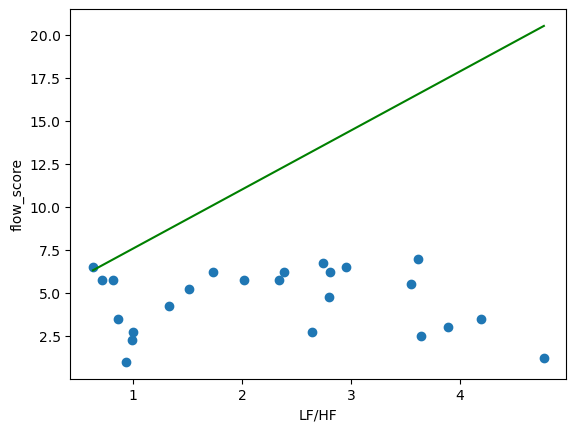

In [14]:
x = flow_dataset["kubios_lf/hf"]
xlabel = "LF/HF"

y = flow_dataset[["questionnaire_average"]]
ylabel = "flow_score"

result2 = smf.ols('questionnaire_average ~ concentration_FCz', data=flow_dataset).fit()

#graph
plt.scatter(x, y)
x = x.sort_values()
b0_2, b1_2 = result2.params
plt.plot(x, b0_2 + b1_2*x, 'g')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.savefig(f"{repository_path}/csv/analysis_results/{Constants.folder_name}/image/{ylabel}_1next.png")
plt.show()

# 2次

In [ ]:
x = flow_dataset["concentration_mean"]
xlabel = "mean_PLI"

y = flow_dataset[["questionnaire_average"]]
ylabel = "flow_score"

result2 = smf.ols('questionnaire_average ~ concentration_FCz + np.power(concentration_FCz, 2)', data=flow_dataset).fit()

#graph
plt.scatter(x, y)
x = x.sort_values()
b0_2, b1_2, b2_2 = result2.params
plt.plot(x, b0_2 + b1_2*x + b2_2*x**2, 'g')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.savefig(f"{repository_path}/csv/analysis_results/{Constants.folder_name}/image//{xlabel}_{ylabel}_2next.png")
plt.show()

# overloadを抜いたやつで分析してみる

In [ ]:
# 使用するデータセットは一つなので，ここでまとめて作っちゃいましょう

for i,target_phase in enumerate(Constants.target_phases):
    
    if target_phase == "overload":
        continue
    
    for j,path in enumerate(pathes):

        df = pd.read_csv(path,index_col=0).fillna(0)
        # column
        # row
        df = df.loc[[target_phase]] # seriesとして取り出したいときはこっち
        if j == 0 and i == 0:
            print("flow_dataset初期化")
            flow_dataset = df
        else:
            flow_dataset = pd.concat([flow_dataset, df], axis=0)
        

for i,target_phase in enumerate(Constants.target_phases):


    export_data = {    
        "target": Constants.target_columns,
        "linear-p": [],
        "linear-rsquared": [],
        "linear-rsquared_adj": [],
        "linear-coef": [],
        "nonlinear-p": [],
        "nonlinear-rsquared": [],
        "nonlinear-rsquared_adj": [],
        "nonlinear-coef": [],
    }

    for target_column in Constants.target_columns:
        
        x = flow_dataset[target_column]
        y = flow_dataset[["questionnaire_average"]]
        
        for k in ["linear", "nonlinear"]:
            if k=="linear":
                # 線形単回帰
                X = sm.add_constant(x)
                model = sm.OLS(y, X)
                results = model.fit()

                export_data["linear-p"].append(results.pvalues[target_column])
                export_data["linear-rsquared"].append(results.rsquared)
                export_data["linear-rsquared_adj"].append(results.rsquared_adj)
                export_data["linear-coef"].append(results.params[target_column])
            if k=="nonlinear":
                # ２次単回帰
                x = x[:,np.newaxis]
                polynomial_features= PolynomialFeatures(degree=2)
                xp = polynomial_features.fit_transform(x)
                xp.shape

                model = sm.OLS(y, xp)
                
                results = model.fit()
                
                export_data["nonlinear-p"].append(results.pvalues[pvalue_index])
                export_data["nonlinear-rsquared"].append(results.rsquared)
                export_data["nonlinear-rsquared_adj"].append(results.rsquared_adj)
                export_data["nonlinear-coef"].append(results.params[pvalue_index])
    
    print(f"\nsaving {target_phase} phase regression results...\n")
    df = pd.DataFrame(export_data)   
    print(df)
    save_path = f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}/regression/all_regressiton_without_overload.csv"
    df.to_csv(save_path)  

# 線形重回帰分析（マルチこに気をつけよう）

In [ ]:
# x = flow_dataset[["bpm", "ibi","mean_3ch"]]
# y = flow_dataset[["questionnaire_average"]]

# #全要素が1の列を説明変数の先頭に追加,切片をつけるために必ず必要
# X = sm.add_constant(x)
 
# #モデルの設定
# model = sm.OLS(y, X)
 
# #回帰分析の実行
# results = model.fit()
 
# #結果の詳細を表示
# print(results.summary())

## いい結果のように思えるが、多重共線性により偽の有意性が出てしまっている

### 参考
- https://takacity.blog.fc2.com/blog-entry-305.html
- https://self-development.info/%E3%80%90%E5%88%9D%E5%BF%83%E8%80%85%E8%84%B1%E5%87%BA%E3%80%91statsmodels%E3%81%AB%E3%82%88%E3%82%8B%E9%87%8D%E5%9B%9E%E5%B8%B0%E5%88%86%E6%9E%90%E7%B5%90%E6%9E%9C%E3%81%AE%E8%A6%8B%E6%96%B9/
- https://teratail.com/questions/256310

In [ ]:
# 決定係数
# 0.9以上	非常によい
# 0.7以上0.9未満	よい
# 0.5以上0.7未満	あまりよくない
# 0.5未満	悪い

# Dep. Variable:     questionnaire_average   R-squared:                       0.915（決定係数。説明変数が目的変数をどれくらい説明できるか）
# Model:                               OLS   Adj. R-squared:                  0.893（自由度調整済み決定係数）
# Method:                    Least Squares   F-statistic:                     42.82（F値）
# Date:                   Fri, 13 Jan 2023   Prob (F-statistic):            0.00282（F値の現れる確率）
# Time:                           12:17:03   Log-Likelihood:                 2.8630
# No. Observations:           データの行数   AIC:                            -1.726
# Df Residuals:               残差の自由度   BIC:                            -2.142
# Df Model:                   要因の自由度                                        
# Covariance Type:  nonrobust（変数間の相関関係）


#       coef（回帰係数。傾き）    std err（標準誤差）  t      P>|t|      [0.025  0.975]
# ------------------------------------------------------------------------------
# const          7.3625      0.174     42.246      0.000       6.879       7.846
# lf         -6.729e-06   1.03e-06     -6.544      0.003   -9.58e-06   -3.87e-06
# ==============================================================================
# Omnibus:                          nan   Durbin-Watson:                   1.765
# Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.156
# Skew:                          -0.179   Prob(JB):                        0.925
# Kurtosis:                       2.296   Cond. No.                     3.93e+05
# ==============================================================================

In [ ]:
dir(results)

In [ ]:
print(results.__doc__)

In [ ]:
dir(results.params)

- [pandas dictionary出力](https://note.nkmk.me/python-pandas-to-csv/)
- [pandas dictionary出力](https://atmarkit.itmedia.co.jp/ait/articles/2109/14/news024.html)